Text Classification



In [ ]:
import pandas as pd
import os
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [ ]:


!wget https://raw.githubusercontent.com/yonwu/nlp_lab2/main/bbc_text.csv



--2024-02-13 09:37:03--  https://raw.githubusercontent.com/yonwu/nlp_lab2/main/bbc_text.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5059719 (4.8M) [text/plain]
Saving to: ‘bbc_text.csv’

bbc_text.csv        100%[===================>]   4.83M  --.-KB/s    in 0.07s   

2024-02-13 09:37:04 (65.0 MB/s) - ‘bbc_text.csv’ saved [5059719/5059719]



In [ ]:
bbc = pd.read_csv('bbc_text.csv', delimiter = ',')
bbc.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [ ]:

random_indices = np.random.choice(bbc.index, 100, replace=False)

bbc_100 = bbc.iloc[random_indices]

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)

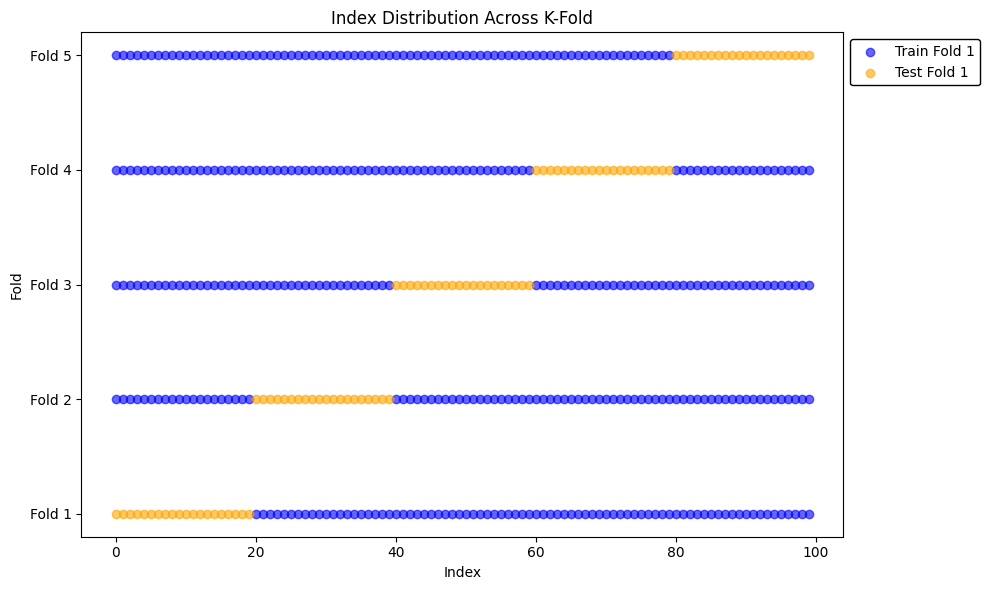

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for i, (train_index, test_index) in enumerate(kf.split(bbc_100)):
    plt.scatter(train_index, [i] * len(train_index), alpha=0.6, label=f'Train Fold {i+1}' if i == 0 else "", color='blue')

    plt.scatter(test_index, [i] * len(test_index), alpha=0.6, label=f'Test Fold {i+1}' if i == 0 else "", color='orange')


plt.xlabel('Index')
plt.ylabel('Fold')
plt.title('Index Distribution Across K-Fold')
plt.yticks(np.arange(5), [f'Fold {i+1}' for i in range(5)])

legend = plt.legend(frameon=True, loc='upper left', bbox_to_anchor=(1, 1))
frame = legend.get_frame()
frame.set_color('white')
frame.set_edgecolor('black')
frame.set_alpha(1)  # Adjust transparency: 0 is transparent, 1 is opaque

plt.tight_layout()
plt.show()

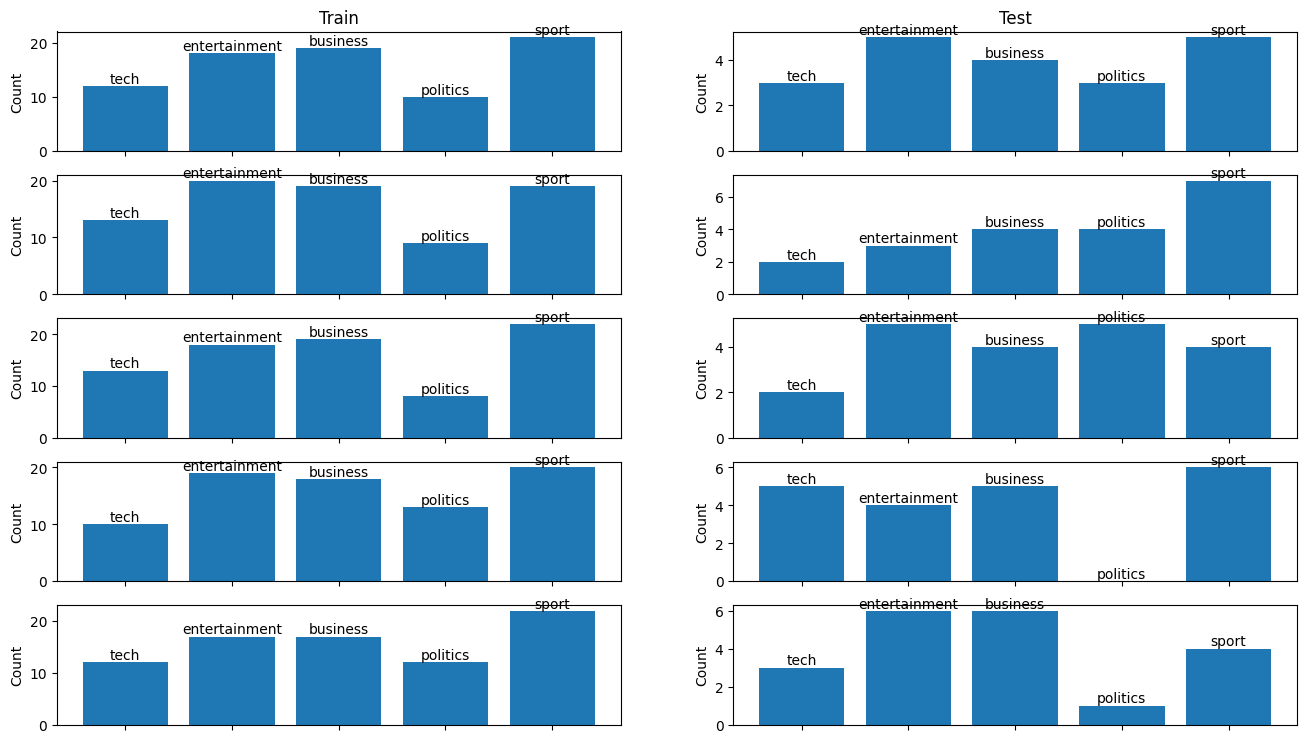

In [ ]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(5, 2)

fig.set_size_inches(16, 9)

classes = bbc_100["category"].unique()

axes[0][0].set_title("Train")
axes[0][1].set_title("Test")

for i, (train_index, test_index) in enumerate(kf.split(bbc_100)):
    def plot(index, axis):
        counts = [(bbc_100.iloc[index]["category"] == cls).sum() for cls in classes]
        bar_container = axis.bar(range(len(classes)), counts)
        axis.bar_label(bar_container, labels=classes)
        axis.set_ylabel("Count")
        axis.set_xticklabels([])

    plot(train_index, axes[i][0])
    plot(test_index, axes[i][1])

fig.show()


Classification using Naive Bayes



In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


def run_pipeline(vectorizer, classifier, n_splits=5):
    pipeline = Pipeline([
        (type(vectorizer).__name__, vectorizer),
        (type(classifier).__name__, classifier),
    ])

    accuracy_scores = []
    f1_scores = []

    for i, (train_index, test_index) in enumerate(KFold(n_splits=n_splits).split(bbc)):
        X_train = bbc.iloc[train_index]["text"]
        X_test = bbc.iloc[test_index]["text"]
        y_train = bbc.iloc[train_index]["category"]
        y_test = bbc.iloc[test_index]["category"]

        pipeline.fit(X_train, y_train)

        y_pred = pipeline.predict(X_test)

        print(f"{i}. ======================\n\n")

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="weighted")

        print(f"Accuracy: {accuracy}")
        print(f"F1: {f1}\n\n")

        accuracy_scores.append(accuracy)
        f1_scores.append(f1)

    print(f"Average accuracy: {np.array(accuracy_scores).mean()}")
    print(f"Average f1: {np.array(f1_scores).mean()}")



In [ ]:

run_pipeline(CountVectorizer(), MultinomialNB())

0. ======================


Accuracy: 0.9707865168539326
F1: 0.9709265123624954


1. ======================


Accuracy: 0.9842696629213483
F1: 0.9843102223371976


2. ======================


Accuracy: 0.9820224719101124
F1: 0.9821380918815923


3. ======================


Accuracy: 0.9595505617977528
F1: 0.959608771377554


4. ======================


Accuracy: 0.9730337078651685
F1: 0.9730268327178438


Average accuracy: 0.973932584269663
Average f1: 0.9740020861353367


Baseline Classifier




In [ ]:
from sklearn.dummy import DummyClassifier

run_pipeline(CountVectorizer(), DummyClassifier(strategy="stratified"))

0. ======================


Accuracy: 0.1752808988764045
F1: 0.1759888524105887


1. ======================


Accuracy: 0.20449438202247192
F1: 0.20330973652217033


2. ======================


Accuracy: 0.19101123595505617
F1: 0.1879451789124767


3. ======================


Accuracy: 0.1842696629213483
F1: 0.18227722850508193


4. ======================


Accuracy: 0.18202247191011237
F1: 0.1846663731420726


Average accuracy: 0.18741573033707865
Average f1: 0.18683747389847807


Is the result from the baseline classifier justified?



Grid Search

In [ ]:


import spacy
nlp = spacy.load('en_core_web_sm', disable=["tagger", "parser", "ner"])

def preprocess(text):
    doc = nlp(text)

    final_key=[]
    for token in doc:
        if token.is_stop==False and token.lemma_.isalpha():

           final_key.append(token.lemma_)

    return final_key

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'vectorizer__ngram_range':[(1,1), (1,2), (1,3)],
          'vectorizer__tokenizer': [preprocess, None],
          'bayes__alpha': [1, 0.1]}

pipeline = Pipeline([
    ("vectorizer", CountVectorizer()),
    ("bayes", MultinomialNB())
])

gridCV = GridSearchCV(pipeline, params, cv=5)
gridCV.fit(bbc["text"], bbc["category"])




GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('bayes', MultinomialNB())]),
             param_grid={'bayes__alpha': [1, 0.1],
                         'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'vectorizer__tokenizer': [<function preprocess at 0x79bc6e5cd7e0>,
                                                   None]})

In [ ]:
print(gridCV.best_params_)

{'bayes__alpha': 0.1, 'vectorizer__ngram_range': (1, 2), 'vectorizer__tokenizer': <function preprocess at 0x79bc6e5cd7e0>}


best parameters

In [ ]:
## to do: Use the best parameters to run the training(pipleline NB) again.
run_pipeline(CountVectorizer(ngram_range=(1, 2), tokenizer=preprocess), MultinomialNB(alpha=0.1))

0. ======================


Accuracy: 0.9842696629213483
F1: 0.9843731284969235


1. ======================


Accuracy: 0.9842696629213483
F1: 0.9843623384228196


2. ======================


Accuracy: 0.9820224719101124
F1: 0.9820507044571445


3. ======================


Accuracy: 0.9730337078651685
F1: 0.9730274218454243


4. ======================


Accuracy: 0.9752808988764045
F1: 0.9752623870209134


Average accuracy: 0.9797752808988763
Average f1: 0.979815196048645


Fine-tuning using BERT


In [3]:
!pip install transformers torch
!pip uninstall tensorflow-probability --yes
!pip install fastapi==0.104.1 typing_extensions==4.8.0 gradio==3.41.0

Found existing installation: tensorflow-probability 0.23.0
Uninstalling tensorflow-probability-0.23.0:
  Successfully uninstalled tensorflow-probability-0.23.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.2/298.2 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 11.7 MB/s 

In [4]:
import pandas as pd
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split

In [ ]:
# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
df = pd.read_csv('bbc_text.csv', delimiter = ',')

# Tokenize text
max_length = 512  # or another value suitable for your text
df['input_ids'] = df['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=max_length, truncation=True))

# Pad sequences
max_len = max([len(sen) for sen in df['input_ids']])
df['input_ids'] = df['input_ids'].apply(lambda x: x + [0] * (max_len - len(x)))

# Convert labels to numbers
label_map = {label: idx for idx, label in enumerate(df['category'].unique())}
df['labels'] = df['category'].map(label_map)

# Split data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, dataframe):
        self.labels = dataframe['labels']
        self.text = dataframe['input_ids']

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels.iloc[idx]
        text = self.text.iloc[idx]
        return torch.tensor(text), torch.tensor(label)

# Create dataset
train_dataset = TextDataset(train_df)
test_dataset = TextDataset(test_df)

# Create dataloaders
batch_size = 16  # Adjust based on your GPU memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
from transformers import BertForSequenceClassification, AdamW

# Load BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_map))

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

# Initialize optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
epochs = 3  # or more based on your dataset size and model complexity
for epoch in range(epochs):
    model.train()

    print("\n")

    count = 0
    length = len(train_loader)

    for batch in train_loader:
        b_input_ids, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_labels = b_labels.to(device)

        # Forward pass
        outputs = model(b_input_ids, labels=b_labels)

        # Backward pass and optimization
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        count += 1
        print(f"\rEpoch {epoch} progress: {count}/{length}", end="")

    print(f'\nEpoch {epoch} complete.')


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# Evaluation loop
model.eval()
predictions, true_labels = [], []
for batch in test_loader:
    b_input_ids, b_labels = batch
    b_input_ids = b_input_ids.to(device)
    b_labels = b_labels.to(device)

    with torch.no_grad():
        outputs = model(b_input_ids)

    logits = outputs.logits
    predictions.extend(torch.argmax(logits, dim=1).tolist())
    true_labels.extend(b_labels.tolist())

accuracy = accuracy_score(true_labels, predictions)
score_f1 = f1_score(true_labels, predictions, average='weighted')

print(f'Test Accuracy: {accuracy}')
print(f" Score f1: {score_f1}")


Test Accuracy: 0.9820224719101124
 Score f1: 0.9820340429317881


In [9]:
from transformers import BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

n_splits = 5
kf = KFold(n_splits=n_splits)
batch_size = 16

print("\n")

accuracies = np.zeros(n_splits)
f1_scores = np.zeros(n_splits)

for i, (train_index, test_index) in enumerate(kf.split(df)):
    print(f"Fold {i} ========================================\n\n")

    train_dataset = TextDataset(df.iloc[train_index])
    test_dataset = TextDataset(df.iloc[test_index])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_map))
    device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
    optimizer = AdamW(model.parameters(), lr=2e-5)

    model.to(device)

    epochs = 3
    for epoch in range(epochs):
        model.train()

        print("\n")

        count = 0
        length = len(train_loader)

        for batch in train_loader:
            b_input_ids, b_labels = batch
            b_input_ids = b_input_ids.to(device)
            b_labels = b_labels.to(device)

            outputs = model(b_input_ids, labels=b_labels)

            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            count += 1
            print(f"\rEpoch {epoch} progress: {count}/{length}", end="")

        print(f'\nEpoch {epoch} complete.')

    model.eval()
    predictions, true_labels = [], []

    for batch in test_loader:
        b_input_ids, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_labels = b_labels.to(device)

        with torch.no_grad():
            outputs = model(b_input_ids)

        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=1).tolist())
        true_labels.extend(b_labels.tolist())

    accuracy = accuracy_score(true_labels, predictions)
    score_f1 = f1_score(true_labels, predictions, average='weighted')

    print(f"\nAccuracy: {accuracy}")
    print(f"\nF1 score: {score_f1}")

    accuracies[i] = accuracy
    f1_scores[i] = score_f1

print(f"\nAverage accuracy: {accuracies.mean()}")
print(f"\nAverage F1 score: {f1_scores.mean()}")




Fold 0 ========================================




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.




Epoch 0 progress: 112/112
Epoch 0 complete.


Epoch 1 progress: 112/112
Epoch 1 complete.


Epoch 2 progress: 112/112
Epoch 2 complete.

Accuracy: 0.9820224719101124

F1 score: 0.982044475305806
Fold 1 ========================================




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.




Epoch 0 progress: 112/112
Epoch 0 complete.


Epoch 1 progress: 112/112
Epoch 1 complete.


Epoch 2 progress: 112/112
Epoch 2 complete.

Accuracy: 0.9865168539325843

F1 score: 0.9865654258430792
Fold 2 ========================================




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.




Epoch 0 progress: 112/112
Epoch 0 complete.


Epoch 1 progress: 112/112
Epoch 1 complete.


Epoch 2 progress: 112/112
Epoch 2 complete.

Accuracy: 0.9842696629213483

F1 score: 0.984335142232225
Fold 3 ========================================




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.




Epoch 0 progress: 112/112
Epoch 0 complete.


Epoch 1 progress: 112/112
Epoch 1 complete.


Epoch 2 progress: 112/112
Epoch 2 complete.

Accuracy: 0.9730337078651685

F1 score: 0.9729058974870609
Fold 4 ========================================




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.




Epoch 0 progress: 112/112
Epoch 0 complete.


Epoch 1 progress: 112/112
Epoch 1 complete.


Epoch 2 progress: 112/112
Epoch 2 complete.

Accuracy: 0.9775280898876404

F1 score: 0.9775094575994605

Average accuracy: 0.9806741573033708

Average F1 score: 0.9806720796935263


AI-based application Demo

In [ ]:
import gradio as gr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def predict(text):
    # Preprocess the text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = inputs.to(device)
    # Get predictions
    with torch.no_grad():
        logits = model(**inputs).logits
    # Convert logits to probabilities
    probabilities = torch.softmax(logits, dim=1).squeeze()
    # Map probabilities to label names (assuming label_map from earlier steps)
    predictions = {label: prob.item() for label, prob in zip(label_map.keys(), probabilities)}


    return predictions

# Create Gradio interface
iface = gr.Interface(
    fn=predict,
    inputs=gr.inputs.Textbox(lines=2, placeholder="Enter Text Here..."),
    outputs=gr.outputs.Label(num_top_classes=3)
)

iface.launch()


<ipython-input-10-54d0a59e61b5>:23: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  inputs=gr.inputs.Textbox(lines=2, placeholder="Enter Text Here..."),
<ipython-input-10-54d0a59e61b5>:23: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  inputs=gr.inputs.Textbox(lines=2, placeholder="Enter Text Here..."),
<ipython-input-10-54d0a59e61b5>:23: GradioDeprecationWarning: `numeric` parameter is deprecated, and it has no effect
  inputs=gr.inputs.Textbox(lines=2, placeholder="Enter Text Here..."),
<ipython-input-10-54d0a59e61b5>:24: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  outputs=gr.outputs.Label(num_top_classes=3)
<ipython-input-10-54d0a59e61b5>:24: GradioUnusedKwargWarning: You have unused kwarg parameters in Label, please remo

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

![gradio](gradio.png)